In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
sns.set(rc={'figure.figsize':(16,9)})

#Предобработка данных

In [47]:
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

In [15]:
events_data.head()

step_id   timestamp      action  user_id
0    32815  1434340848      viewed    17632
1    32815  1434340848      passed    17632
2    32815  1434340848  discovered    17632
3    32811  1434340895  discovered    17632
4    32811  1434340895      viewed    17632

In [48]:
submissions_data.head()

step_id   timestamp submission_status  user_id
0    31971  1434349275           correct    15853
1    31972  1434348300           correct    15853
2    31972  1478852149             wrong    15853
3    31972  1478852164           correct    15853
4    31976  1434348123             wrong    15853

In [16]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [54]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data['date'].dt.date

In [49]:
submissions_data['date'] =\
 pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data['date'].dt.date


In [23]:
events_data.head()

step_id   timestamp      action  user_id                date         day
0    32815  1434340848      viewed    17632 2015-06-15 04:00:48  2015-06-15
1    32815  1434340848      passed    17632 2015-06-15 04:00:48  2015-06-15
2    32815  1434340848  discovered    17632 2015-06-15 04:00:48  2015-06-15
3    32811  1434340895  discovered    17632 2015-06-15 04:01:35  2015-06-15
4    32811  1434340895      viewed    17632 2015-06-15 04:01:35  2015-06-15

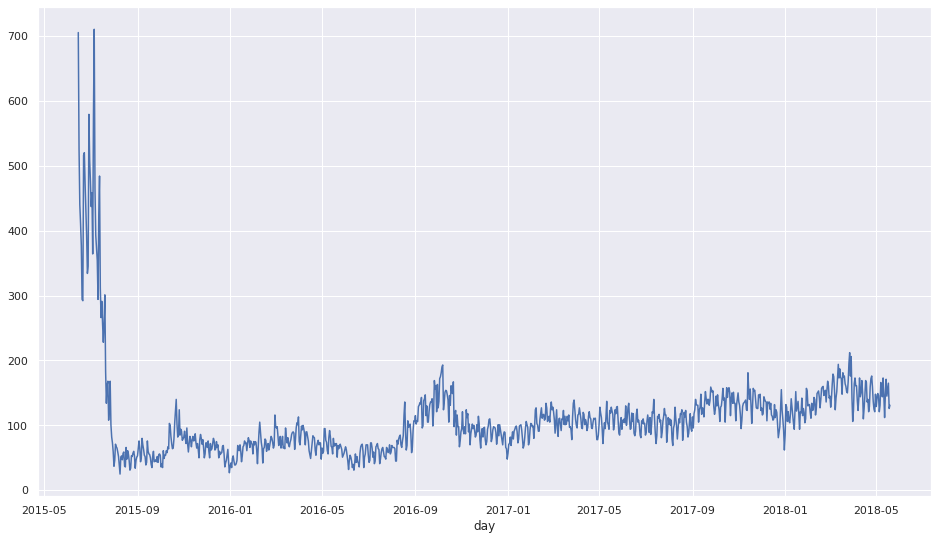

In [31]:
events_data.groupby('day')\
    .user_id.nunique().plot()
pass

In [87]:
users_events_data = events_data.pivot_table(index='user_id',\
                        columns='action',\
                        values='step_id',\
                        aggfunc='count', fill_value=0).reset_index()

In [51]:
users_scores = submissions_data.pivot_table(index='user_id',\
                        columns='submission_status',\
                        values='step_id',\
                        aggfunc='count', fill_value=0).reset_index()

In [52]:
users_scores.head()

submission_status  user_id  correct  wrong
0                        2        2      0
1                        3       29     23
2                        5        2      2
3                        8        9     21
4                       14        0      1

In [60]:
gap_data = events_data[['user_id', 'day', 'timestamp']]\
    .drop_duplicates(subset=['user_id', 'day'])\
    .groupby('user_id')['timestamp'].apply(list)\
    .apply(np.diff).values

In [61]:
gap_data = pd.Series(np.concatenate(gap_data)/(24 * 60 *60))

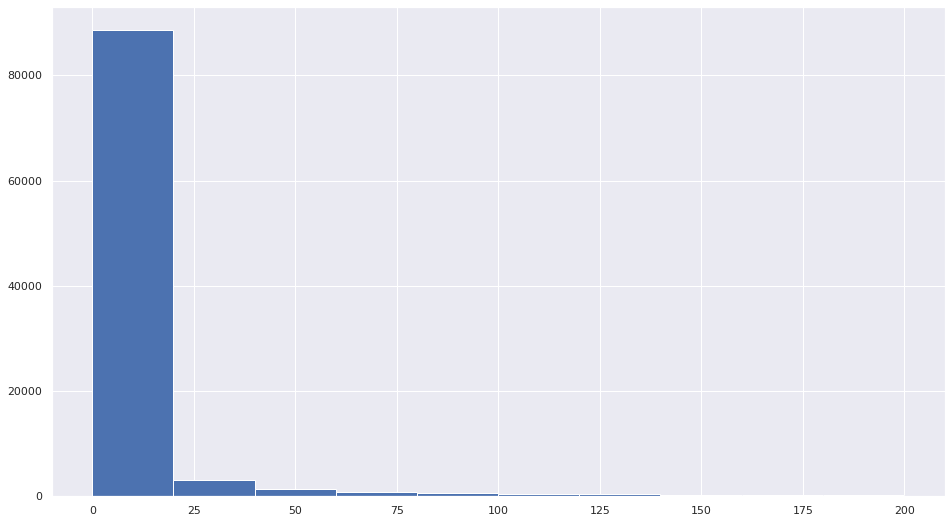

In [63]:
gap_data[gap_data<200].hist()
pass

In [71]:
gap_data.quantile(0.95)

59.760440972222156

In [72]:
gap_data.quantile(0.90)

18.325995370370403

30 дней не заходил будем считать что дропнулся с курса

In [67]:
events_data.tail()

step_id   timestamp      action  user_id                date  \
3480698    33375  1526772685      viewed    11677 2018-05-19 23:31:25   
3480699    32815  1526772750      viewed     5198 2018-05-19 23:32:30   
3480700    32815  1526772750  discovered     5198 2018-05-19 23:32:30   
3480701    32815  1526772750      passed     5198 2018-05-19 23:32:30   
3480702    33892  1526772811      viewed    18526 2018-05-19 23:33:31   

                day  
3480698  2018-05-19  
3480699  2018-05-19  
3480700  2018-05-19  
3480701  2018-05-19  
3480702  2018-05-19

In [76]:
users_data = events_data.groupby('user_id', as_index= False)\
    .agg({'timestamp': 'max'})\
    .rename(columns={'timestamp': 'last_timestamp'})

In [74]:
now = 1526772811
drop_out_threshold = 30*24*60*60

In [77]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold

In [79]:
users_data.head()

user_id  last_timestamp  is_gone_user
0        1      1472827464          True
1        2      1519226966          True
2        3      1444581588          True
3        5      1499859939          True
4        7      1521634660          True

In [78]:
users_scores.head()

submission_status  user_id  correct  wrong
0                        2        2      0
1                        3       29     23
2                        5        2      2
3                        8        9     21
4                       14        0      1

In [81]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [82]:
users_data = users_data.fillna(0)

In [84]:
users_data.head(10)

user_id  last_timestamp  is_gone_user  correct  wrong
0        1      1472827464          True      0.0    0.0
1        2      1519226966          True      2.0    0.0
2        3      1444581588          True     29.0   23.0
3        5      1499859939          True      2.0    2.0
4        7      1521634660          True      0.0    0.0
5        8      1481466913          True      9.0   21.0
6        9      1484999497          True      0.0    0.0
7       11      1526140625         False      0.0    0.0
8       14      1436368676          True      0.0    1.0
9       16      1513162585          True     77.0  106.0

In [88]:
users_data = users_data.merge(users_events_data, on='user_id', how='outer')

In [94]:
users_days = events_data.groupby('user_id',as_index=False)\
    .day.nunique()
users_data = users_data.merge(users_days, on='user_id', how='outer')

In [98]:
users_data['passed_corse'] = users_data.passed > 170

In [99]:
users_data.head()

user_id  last_timestamp  is_gone_user  correct  wrong  discovered  passed  \
0        1      1472827464          True      0.0    0.0           1       0   
1        2      1519226966          True      2.0    0.0           9       9   
2        3      1444581588          True     29.0   23.0          91      87   
3        5      1499859939          True      2.0    2.0          11      11   
4        7      1521634660          True      0.0    0.0           1       1   

   started_attempt  viewed  day  passed_corse  
0                0       1    1         False  
1                2      10    2         False  
2               30     192    7         False  
3                4      12    2         False  
4                0       1    1         False

In [100]:
users_data.groupby('passed_corse').count()

user_id  last_timestamp  is_gone_user  correct  wrong  \
passed_corse                                                          
False           17809           17809         17809    17809  17809   
True             1425            1425          1425     1425   1425   

              discovered  passed  started_attempt  viewed    day  
passed_corse                                                      
False              17809   17809            17809   17809  17809  
True                1425    1425             1425    1425   1425

In [96]:
users_data.user_id.nunique()

19234

In [97]:
events_data.user_id.nunique()

19234